In [1]:
import sys
from pathlib import Path

here = Path.cwd().resolve()
repo_root = here if (here / "src").exists() else here.parents[1]

if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

### Simple attention mechanism - calculating context vector for one token (to understand)

### assume embedding dimension = 3 and already input embeddings are calculated

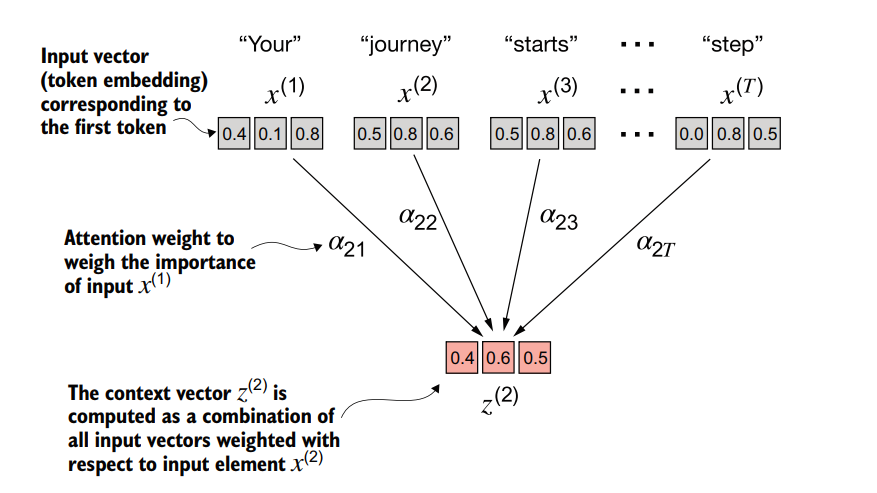

In [2]:
import torch
inputs = torch.tensor(
[[0.43, 0.15, 0.89], # Your (x^1)
[0.55, 0.87, 0.66], # journey (x^2)
[0.57, 0.85, 0.64], # starts (x^3)
[0.22, 0.58, 0.33], # with (x^4)
[0.77, 0.25, 0.10], # one (x^5)
[0.05, 0.80, 0.55]] # step (x^6)
)

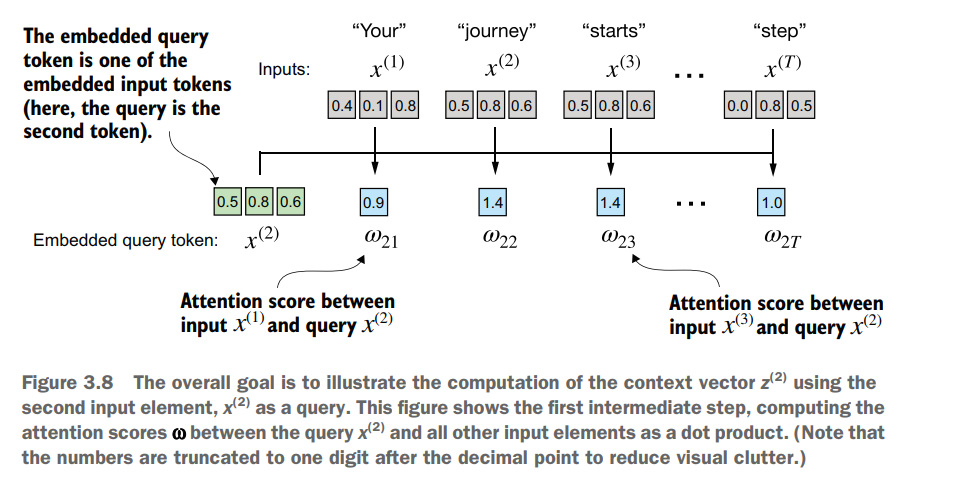

In [3]:
# query token - i need to calcualte the attention score for the token "journey"
query = inputs[1] # (x^2)

In [4]:
# attention scores
# attention_scores = torch.matmul(inputs, query) -- easier way

attention_scores = torch.zeros(inputs.shape[0])
for i in range(inputs.shape[0]):
    attention_scores[i] = torch.dot(inputs[i], query)
print("Attention scores: ", attention_scores)

Attention scores:  tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


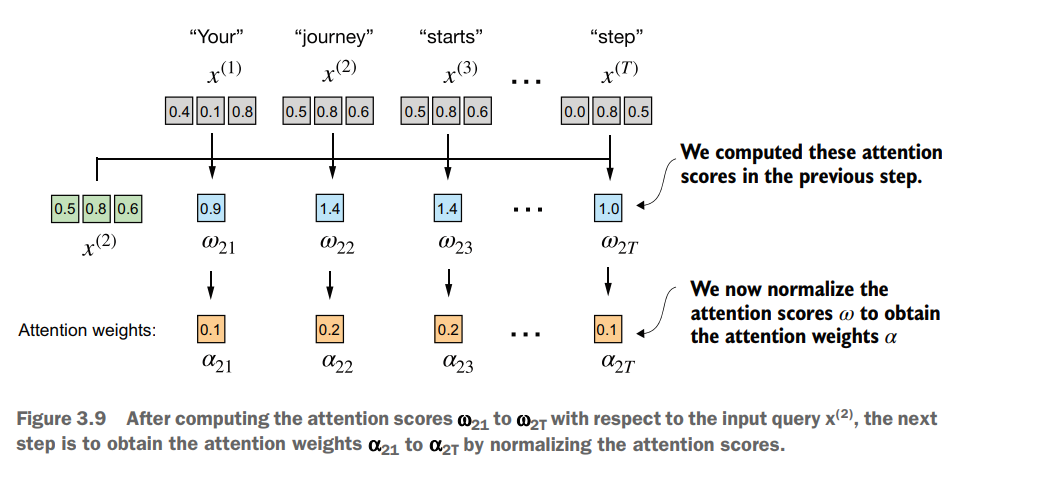

In [5]:
# attention weights - normalized attention scores- softmax
attention_weights = torch.softmax(attention_scores, dim=-1)

In [6]:
attention_weights

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])

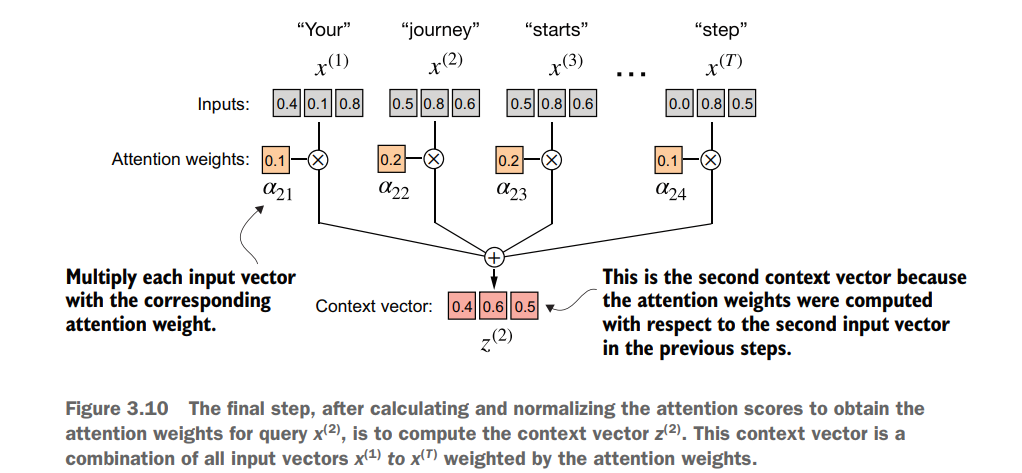

In [7]:
# context vector for the token "journey"
# attention_weight * inputs = context vector
context_vector = torch.zeros(inputs.shape[1])
for i in range(inputs.shape[0]):
    context_vector += attention_weights[i] * inputs[i]

context_vector.shape


torch.Size([3])

In [8]:
print(context_vector)

tensor([0.4419, 0.6515, 0.5683])


### Now calculate at once all attattion weights

In [9]:
attention_scores= torch.matmul(inputs, inputs.T)
attention_weights = torch.softmax(attention_scores, dim=-1) # normalized attention scores
print(attention_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [10]:
## all the context vectors at once
context_vectors = torch.matmul(attention_weights, inputs)
print(context_vectors)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


# With trainable wights

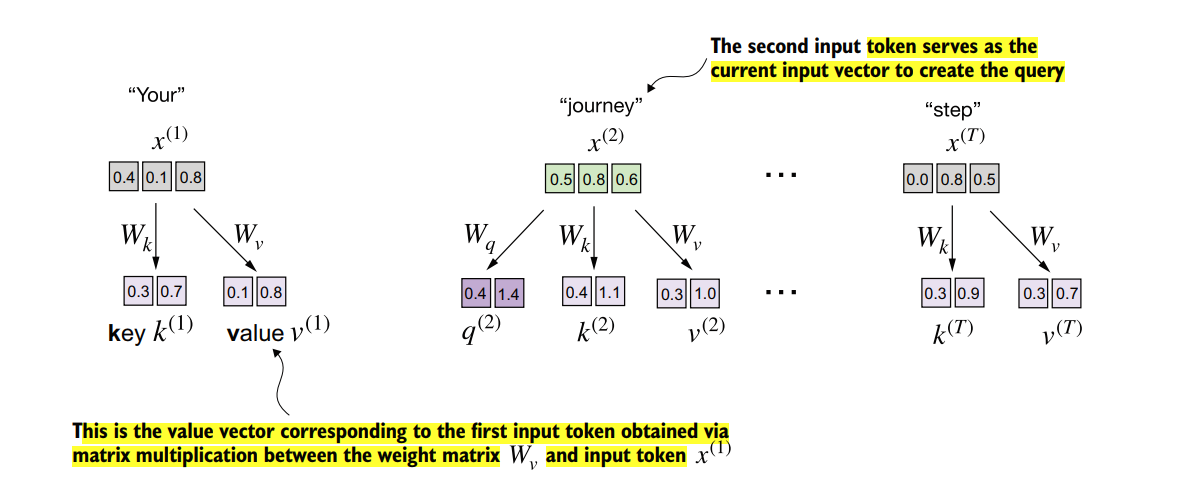

In [11]:
# qyery is the second token "journey"
x_2 = inputs[1]
print(x_2)

tensor([0.5500, 0.8700, 0.6600])


In [13]:
d_in = 3
d_out =2 # ideally d_in = d_out

In [14]:
# randomly intitalize trainable query, key and value matrix
# output embedding size = 2
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [15]:
W_query 

Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])

In [16]:
# query, key and value vectors of the token "journey"
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key     
value_2 = x_2 @ W_value
print("query_2:", query_2)
print("key_2:", key_2)  
print("value_2:", value_2)

query_2: tensor([0.4306, 1.4551])
key_2: tensor([0.4433, 1.1419])
value_2: tensor([0.3951, 1.0037])


In [17]:
# key and value vectors of all the tokens
keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


In [18]:
# Now unscaled attention scores for all the tokesn with respect to the query token "journey"
unscaled_attention_scores = torch.zeros(inputs.shape[0])
for i in range(inputs.shape[0]):
    unscaled_attention_scores[i] = torch.dot(keys[i], query_2) # attention score of each key with respect to the query
print("Unscaled attention scores:", unscaled_attention_scores)

Unscaled attention scores: tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


#now we scale the attention scores by dividing
them by the square root of the embedding dimension of the keys (taking the square
root is mathematically the same as exponentiating by 0.5)

In [19]:
keys.shape[-1] # d_k
d_k = keys.shape[-1]

In [20]:

attn_weights_2 = torch.softmax(unscaled_attention_scores / d_k**0.5, dim=-1)

In [21]:
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


In [22]:
# now the context wector for the token "journey" is attention_weight * values
context_vector_2 = attn_weights_2 @ values
print("context_vector_2:", context_vector_2)


context_vector_2: tensor([0.3061, 0.8210])


In [23]:
from src.gpt_blocks.self_attention import SelfAttention_v1, SelfAttention_v2

In [26]:
torch.manual_seed(123)
self_attention = SelfAttention_v1(d_in=3, d_out=10)
context_vectors = self_attention(inputs)
print(context_vectors)

tensor([[1.3629, 1.3005, 0.4713, 0.4145, 0.7686, 0.7866, 0.7880, 0.7637, 0.7953,
         1.3421],
        [1.3996, 1.3355, 0.4813, 0.4233, 0.7913, 0.8080, 0.8113, 0.7785, 0.8149,
         1.3779],
        [1.3971, 1.3331, 0.4806, 0.4227, 0.7898, 0.8065, 0.8098, 0.7774, 0.8134,
         1.3754],
        [1.3035, 1.2455, 0.4531, 0.3990, 0.7325, 0.7530, 0.7514, 0.7379, 0.7613,
         1.2848],
        [1.2869, 1.2316, 0.4456, 0.3933, 0.7237, 0.7445, 0.7428, 0.7275, 0.7494,
         1.2693],
        [1.3400, 1.2789, 0.4651, 0.4091, 0.7542, 0.7734, 0.7734, 0.7550, 0.7831,
         1.3199]], grad_fn=<MmBackward0>)


In [24]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


In [25]:
Wq = sa_v2.W_query.weight.T
Wk = sa_v2.W_key.weight.T
Wv = sa_v2.W_value.weight.T

In [26]:
print(Wk)

tensor([[ 0.4058,  0.2134],
        [-0.4704, -0.2601],
        [ 0.2368, -0.5105]], grad_fn=<PermuteBackward0>)


In [27]:
torch.manual_seed(789)
sa_v1 = SelfAttention_v1(d_in, d_out)
sa_v1.W_key.data = Wk
sa_v1.W_value.data = Wv
sa_v1.W_query.data = Wq

In [28]:
print(sa_v1.W_query)
print(sa_v1.W_key)
print(sa_v1.W_value)


Parameter containing:
tensor([[ 0.3161, -0.1683],
        [ 0.4568, -0.3379],
        [ 0.5118, -0.0918]], requires_grad=True)
Parameter containing:
tensor([[ 0.4058,  0.2134],
        [-0.4704, -0.2601],
        [ 0.2368, -0.5105]], requires_grad=True)
Parameter containing:
tensor([[ 0.2526,  0.5191],
        [-0.1415, -0.0852],
        [-0.1962, -0.2043]], requires_grad=True)


In [29]:
torch.manual_seed(789)
print(sa_v1(inputs))


tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


# Causal Attention

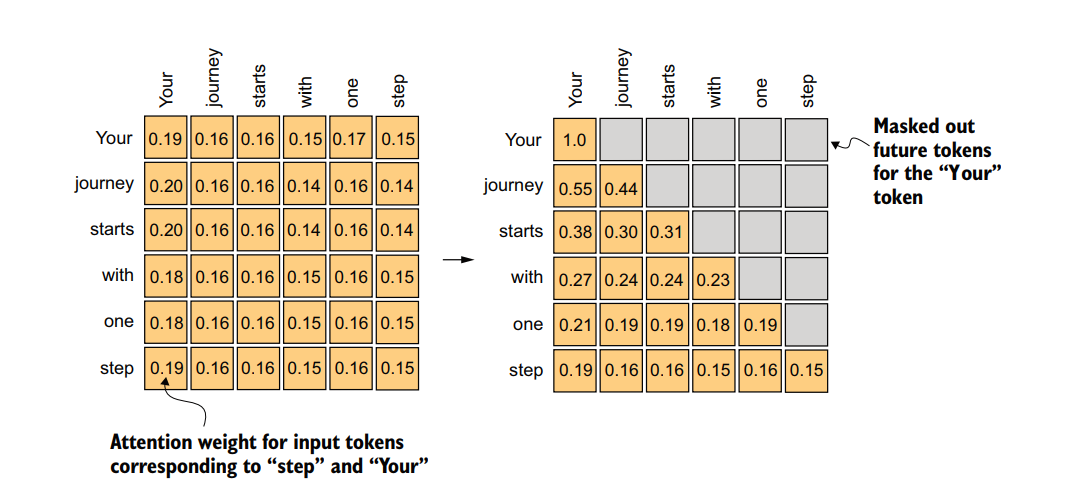

In [27]:
self_attn = SelfAttention_v2(d_in=3, d_out=2)

In [28]:
Q = self_attn.W_query(inputs)
K = self_attn.W_key(inputs)

In [29]:
attn_scores = Q @ K.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1566, 0.1692, 0.1691, 0.1690, 0.1662, 0.1699],
        [0.1623, 0.1748, 0.1746, 0.1614, 0.1624, 0.1644],
        [0.1619, 0.1743, 0.1741, 0.1621, 0.1628, 0.1649],
        [0.1667, 0.1729, 0.1728, 0.1611, 0.1631, 0.1634],
        [0.1560, 0.1622, 0.1623, 0.1756, 0.1702, 0.1738],
        [0.1703, 0.1784, 0.1781, 0.1547, 0.1595, 0.1589]],
       grad_fn=<SoftmaxBackward0>)


In [30]:
# masking matrix
context_lenght = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones((context_lenght, context_lenght)))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [31]:
# mask the attentionweights
mask_simple = attn_weights * mask_simple
print(mask_simple)


tensor([[0.1566, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1623, 0.1748, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1619, 0.1743, 0.1741, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1729, 0.1728, 0.1611, 0.0000, 0.0000],
        [0.1560, 0.1622, 0.1623, 0.1756, 0.1702, 0.0000],
        [0.1703, 0.1784, 0.1781, 0.1547, 0.1595, 0.1589]],
       grad_fn=<MulBackward0>)


In [32]:
# renormalized attention weights
renorm_attention_weights = mask_simple / mask_simple.sum(dim=-1, keepdim=True)
print(renorm_attention_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4814, 0.5186, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3173, 0.3416, 0.3412, 0.0000, 0.0000, 0.0000],
        [0.2475, 0.2567, 0.2565, 0.2392, 0.0000, 0.0000],
        [0.1887, 0.1964, 0.1965, 0.2125, 0.2059, 0.0000],
        [0.1703, 0.1784, 0.1781, 0.1547, 0.1595, 0.1589]],
       grad_fn=<DivBackward0>)


In [33]:
# Causal Attention improvements 
mask = torch.triu(torch.ones(context_lenght, context_lenght), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[-0.0691,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.1479,  0.2531,    -inf,    -inf,    -inf,    -inf],
        [ 0.1287,  0.2329,  0.2313,    -inf,    -inf,    -inf],
        [ 0.1587,  0.2104,  0.2091,  0.1105,    -inf,    -inf],
        [-0.2529, -0.1970, -0.1963, -0.0853, -0.1296,    -inf],
        [ 0.3459,  0.4120,  0.4097,  0.2103,  0.2532,  0.2483]],
       grad_fn=<MaskedFillBackward0>)


In [34]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4814, 0.5186, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3173, 0.3416, 0.3412, 0.0000, 0.0000, 0.0000],
        [0.2475, 0.2567, 0.2565, 0.2392, 0.0000, 0.0000],
        [0.1887, 0.1964, 0.1965, 0.2125, 0.2059, 0.0000],
        [0.1703, 0.1784, 0.1781, 0.1547, 0.1595, 0.1589]],
       grad_fn=<SoftmaxBackward0>)


## Dropout

In [35]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6, 6)
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


In [36]:
torch.manual_seed(123)
print(dropout(attention_scores))

tensor([[1.9990, 1.9088, 0.0000, 0.9506, 0.9152, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.6868, 0.0000, 2.1730],
        [1.8844, 2.9508, 2.9140, 1.6592, 0.0000, 2.1210],
        [0.0000, 1.6868, 1.6592, 0.0000, 0.0000, 1.3130],
        [0.0000, 1.4140, 0.0000, 0.6948, 0.0000, 0.5870],
        [0.0000, 2.1730, 2.1210, 1.3130, 0.5870, 0.0000]])


In [37]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

torch.Size([2, 6, 3])


In [38]:
from src.gpt_blocks.self_attention import CausalAttention
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


In [39]:
context_vecs

tensor([[[-0.5337, -0.1051],
         [-0.5323, -0.1080],
         [-0.5323, -0.1079],
         [-0.5297, -0.1076],
         [-0.5311, -0.1066],
         [-0.5299, -0.1081]],

        [[-0.5337, -0.1051],
         [-0.5323, -0.1080],
         [-0.5323, -0.1079],
         [-0.5297, -0.1076],
         [-0.5311, -0.1066],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)

# Multi Head attention

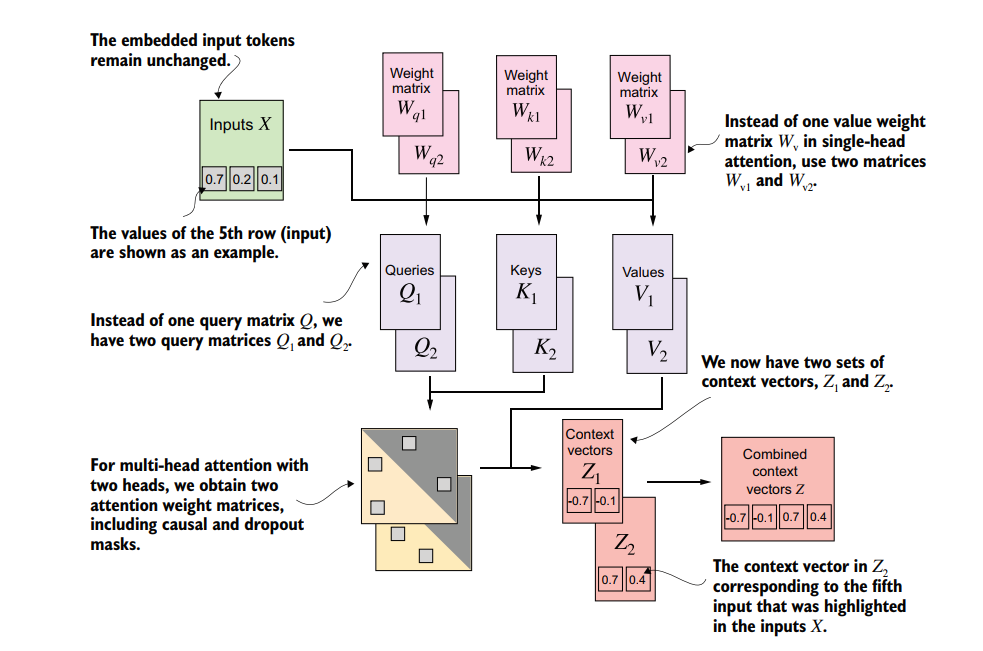

In [40]:
from src.gpt_blocks.self_attention import MultiHeadAttentionWrapper

In [41]:
torch.manual_seed(123)
context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 1

In [42]:
mha = MultiHeadAttentionWrapper(
d_in, d_out, context_length, 0.0, num_heads=2
)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)  # 2 d context vectors for each head hence 4 dimention context vector of each token 

tensor([[[-0.6432, -0.1042],
         [-0.6430, -0.1054],
         [-0.6430, -0.1054],
         [-0.6423, -0.1061],
         [-0.6426, -0.1049],
         [-0.6424, -0.1065]],

        [[-0.6432, -0.1042],
         [-0.6430, -0.1054],
         [-0.6430, -0.1054],
         [-0.6423, -0.1061],
         [-0.6426, -0.1049],
         [-0.6424, -0.1065]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


In [43]:
# Final Multi-head attention with masking and dropout and mixing of heads
from src.gpt_blocks.self_attention import MultiHeadAttention
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in = d_in, d_out=d_out, context_length=context_length, dropout = 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.2595, 0.4014],
         [0.2583, 0.4014],
         [0.2583, 0.4014],
         [0.2575, 0.4031],
         [0.2582, 0.4026],
         [0.2575, 0.4028]],

        [[0.2595, 0.4014],
         [0.2583, 0.4014],
         [0.2583, 0.4014],
         [0.2575, 0.4031],
         [0.2582, 0.4026],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


In [44]:
gpt_mha = MultiHeadAttention(d_in=3, d_out=768, context_length=768, dropout=0.0, num_heads=12)

In [45]:
total_params = sum(p.numel() for p in gpt_mha.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 597504
